# Structural Time Series Demo

Modified from 

https://www.tensorflow.org/probability/examples/Structural_Time_Series_Modeling_Case_Studies_Atmospheric_CO2_and_Electricity_Demand

Details in this blog post:
https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html

### Dependencies & Prerequisites


In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

import collections

import numpy as np

try:
    import tensorflow.compat.v2 as tf
except ModuleNotFoundError:
    %pip install -qq tensorflow
    import tensorflow.compat.v2 as tf
try:
    import tensorflow_probability as tfp
except ModuleNotFoundError:
    %pip install -qq tensorflow-probability
    import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

try:
    import probml_utils as pml
    from probml_utils import latexify, savefig

except ModuleNotFoundError:
    %pip install -qq git+https://github.com/probml/probml-utils.git
    import probml_utils as pml
    from probml_utils import latexify, savefig

tf.enable_v2_behavior()

2022-07-13 19:31:46.923035: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-13 19:31:46.926829: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-13 19:31:46.926840: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Make things Fast!

Before we dive in, let's make sure we're using a GPU for this demo.  

To do this, select "Runtime" -> "Change runtime type" -> "Hardware accelerator" -> "GPU".

The following snippet will verify that we have access to a GPU.

In [2]:
if tf.test.gpu_device_name() != "/device:GPU:0":
    print("WARNING: GPU device not found.")
else:
    print("SUCCESS: Found GPU: {}".format(tf.test.gpu_device_name()))

2022-07-13 19:31:48.701526: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-13 19:31:48.705120: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-13 19:31:48.705135: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-13 19:31:48.705146: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-TRSAF7U): /proc/driver/nvidia/version does not exist


Note: if for some reason you cannot access a GPU, this colab will still work. (Training will just take longer.)

### Plotting setup

Helper methods for plotting time series and forecasts.

In [3]:
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()
sns.set_context("notebook")
%config InlineBackend.figure_format = 'retina'

In [4]:
def plot_forecast(x, y, forecast_mean, forecast_scale, forecast_samples, title, x_locator=None, x_formatter=None):
    """Plot a forecast distribution against the 'true' time series."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast

    ax.plot(x, y, lw=1, color=c1, label="ground truth", markersize=1)

    forecast_steps = np.arange(x[num_steps_train], x[num_steps_train] + num_steps_forecast, dtype=x.dtype)

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1, markersize=1)

    ax.plot(forecast_steps, forecast_mean, lw=1, ls="--", color=c2, label="forecast", markersize=1)
    ax.fill_between(
        forecast_steps, forecast_mean - 2 * forecast_scale, forecast_mean + 2 * forecast_scale, color=c2, alpha=0.2
    )

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax - ymin
    ax.set_ylim([ymin - yrange * 0.1, ymax + yrange * 0.1])
    ax.set_title("{}".format(title))
    ax.legend(frameon=False)

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax

In [5]:
def plot_components(dates, component_means_dict, component_stddevs_dict, x_locator=None, x_formatter=None):
    """Plot the contributions of posterior components in a single figure."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure()
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

        ax = fig.add_subplot(num_components, 1, 1 + i)
        ax.plot(dates, component_mean, lw=1, markersize=1)
        ax.fill_between(
            dates, component_mean - 2 * component_stddev, component_mean + 2 * component_stddev, color=c2, alpha=0.5
        )
        ax.set_title(component_name[0:-1])
        if x_locator is not None:
            # ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict

In [6]:
def plot_components_figs(dates, component_means_dict, component_stddevs_dict, x_locator=None, x_formatter=None):
    """Plot the contributions of posterior components in separate figure."""
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    axes_dict = collections.OrderedDict()
    fig_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure()
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

        # ax = fig.add_subplot(num_components,1,1+i)
        fig, ax = plt.subplots()
        ax.plot(dates, component_mean, lw=1)
        ax.fill_between(
            dates, component_mean - 2 * component_stddev, component_mean + 2 * component_stddev, color=c2, alpha=0.5
        )
        ax.set_title(component_name)
        if x_locator is not None:
            ax.xaxis.set_major_locator(x_locator)
            ax.xaxis.set_major_formatter(x_formatter)
        axes_dict[component_name] = ax
        fig.autofmt_xdate()
        fig.tight_layout()
        fig_dict[component_name] = fig
    return fig_dict

In [7]:
def plot_one_step_predictive(
    dates, observed_time_series, one_step_mean, one_step_scale, x_locator=None, x_formatter=None
):
    """Plot a time series against a model's one-step predictions."""

    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    num_timesteps = one_step_mean.shape[-1]
    ax.plot(dates, observed_time_series, label="observed time series", color=c1)
    ax.plot(dates, one_step_mean, label="one-step prediction", color=c2)
    ax.fill_between(dates, one_step_mean - one_step_scale, one_step_mean + one_step_scale, alpha=0.1, color=c2)
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()
    fig.tight_layout()
    return fig, ax

## Mauna Loa CO2 record

We'll demonstrate fitting a model to the atmospheric CO2 readings from the Mauna Loa observatory.


In [8]:
# stateless RNG
# These are deterministic ops whose behavior is controlled by a int32 Tensor seed of shape [2].
# https://github.com/tensorflow/probability/blob/main/PRNGS.md
seed = tf.constant([42, 42])

### Data

In [9]:
# CO2 readings from Mauna Loa observatory, monthly beginning January 1966
# Original source: http://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record
co2_by_month = np.array(
    "320.62,321.60,322.39,323.70,324.08,323.75,322.38,320.36,318.64,318.10,319.78,321.03,322.33,322.50,323.04,324.42,325.00,324.09,322.54,320.92,319.25,319.39,320.73,321.96,322.57,323.15,323.89,325.02,325.57,325.36,324.14,322.11,320.33,320.25,321.32,322.89,324.00,324.42,325.63,326.66,327.38,326.71,325.88,323.66,322.38,321.78,322.85,324.12,325.06,325.98,326.93,328.14,328.08,327.67,326.34,324.69,323.10,323.06,324.01,325.13,326.17,326.68,327.17,327.79,328.92,328.57,327.36,325.43,323.36,323.56,324.80,326.01,326.77,327.63,327.75,329.73,330.07,329.09,328.04,326.32,324.84,325.20,326.50,327.55,328.55,329.56,330.30,331.50,332.48,332.07,330.87,329.31,327.51,327.18,328.16,328.64,329.35,330.71,331.48,332.65,333.09,332.25,331.18,329.39,327.43,327.37,328.46,329.57,330.40,331.40,332.04,333.31,333.97,333.60,331.90,330.06,328.56,328.34,329.49,330.76,331.75,332.56,333.50,334.58,334.88,334.33,333.05,330.94,329.30,328.94,330.31,331.68,332.93,333.42,334.70,336.07,336.75,336.27,334.92,332.75,331.59,331.16,332.40,333.85,334.97,335.38,336.64,337.76,338.01,337.89,336.54,334.68,332.76,332.55,333.92,334.95,336.23,336.76,337.96,338.88,339.47,339.29,337.73,336.09,333.92,333.86,335.29,336.73,338.01,338.36,340.07,340.77,341.47,341.17,339.56,337.60,335.88,336.02,337.10,338.21,339.24,340.48,341.38,342.51,342.91,342.25,340.49,338.43,336.69,336.86,338.36,339.61,340.75,341.61,342.70,343.57,344.14,343.35,342.06,339.81,337.98,337.86,339.26,340.49,341.38,342.52,343.10,344.94,345.76,345.32,343.98,342.38,339.87,339.99,341.15,342.99,343.70,344.50,345.28,347.06,347.43,346.80,345.39,343.28,341.07,341.35,342.98,344.22,344.97,345.99,347.42,348.35,348.93,348.25,346.56,344.67,343.09,342.80,344.24,345.56,346.30,346.95,347.85,349.55,350.21,349.55,347.94,345.90,344.85,344.17,345.66,346.90,348.02,348.48,349.42,350.99,351.85,351.26,349.51,348.10,346.45,346.36,347.81,348.96,350.43,351.73,352.22,353.59,354.22,353.79,352.38,350.43,348.73,348.88,350.07,351.34,352.76,353.07,353.68,355.42,355.67,355.12,353.90,351.67,349.80,349.99,351.30,352.52,353.66,354.70,355.38,356.20,357.16,356.23,354.81,352.91,350.96,351.18,352.83,354.21,354.72,355.75,357.16,358.60,359.34,358.24,356.17,354.02,352.15,352.21,353.75,354.99,355.99,356.72,357.81,359.15,359.66,359.25,357.02,355.00,353.01,353.31,354.16,355.40,356.70,357.17,358.38,359.46,360.28,359.60,357.57,355.52,353.69,353.99,355.34,356.80,358.37,358.91,359.97,361.26,361.69,360.94,359.55,357.48,355.84,356.00,357.58,359.04,359.97,361.00,361.64,363.45,363.80,363.26,361.89,359.45,358.05,357.75,359.56,360.70,362.05,363.24,364.02,364.71,365.41,364.97,363.65,361.48,359.45,359.61,360.76,362.33,363.18,363.99,364.56,366.36,366.80,365.63,364.47,362.50,360.19,360.78,362.43,364.28,365.33,366.15,367.31,368.61,369.30,368.88,367.64,365.78,363.90,364.23,365.46,366.97,368.15,368.87,369.59,371.14,371.00,370.35,369.27,366.93,364.64,365.13,366.68,368.00,369.14,369.46,370.51,371.66,371.83,371.69,370.12,368.12,366.62,366.73,368.29,369.53,370.28,371.50,372.12,372.86,374.02,373.31,371.62,369.55,367.96,368.09,369.68,371.24,372.44,373.08,373.52,374.85,375.55,375.40,374.02,371.48,370.70,370.25,372.08,373.78,374.68,375.62,376.11,377.65,378.35,378.13,376.61,374.48,372.98,373.00,374.35,375.69,376.79,377.36,378.39,380.50,380.62,379.55,377.76,375.83,374.05,374.22,375.84,377.44,378.34,379.61,380.08,382.05,382.24,382.08,380.67,378.67,376.42,376.80,378.31,379.96,381.37,382.02,382.56,384.37,384.92,384.03,382.28,380.48,378.81,379.06,380.14,381.66,382.58,383.71,384.34,386.23,386.41,385.87,384.45,381.84,380.86,380.86,382.36,383.61,385.07,385.84,385.83,386.77,388.51,388.05,386.25,384.08,383.09,382.78,384.01,385.11,386.65,387.12,388.52,389.57,390.16,389.62,388.07,386.08,384.65,384.33,386.05,387.49,388.55,390.07,391.01,392.38,393.22,392.24,390.33,388.52,386.84,387.16,388.67,389.81,391.30,391.92,392.45,393.37,394.28,393.69,392.59,390.21,389.00,388.93,390.24,391.80,393.07,393.35,394.36,396.43,396.87,395.88,394.52,392.54,391.13,391.01,392.95,394.34,395.61,396.85,397.26,398.35,399.98,398.87,397.37,395.41,393.39,393.70,395.19,396.82,397.92,398.10,399.47,401.33,401.88,401.31,399.07,397.21,395.40,395.65,397.23,398.79,399.85,400.31,401.51,403.45,404.10,402.88,401.61,399.00,397.50,398.28,400.24,401.89,402.65,404.16,404.85,407.57,407.66,407.00,404.50,402.24,401.01,401.50,403.64,404.55,406.07,406.64,407.06,408.95,409.91,409.12,407.20,405.24,403.27,403.64,405.17,406.75,408.05,408.34,409.25,410.30,411.30,410.88,408.90,407.10,405.59,405.99,408.12,409.23,410.92".split(
        ","
    )
).astype(np.float32)

co2_by_month = co2_by_month
num_forecast_steps = 12 * 10  # Forecast the final ten years, given previous data
co2_by_month_training_data = co2_by_month[:-num_forecast_steps]

co2_dates = np.arange("1966-01", "2019-02", dtype="datetime64[M]")
co2_loc = mdates.YearLocator(7)
co2_fmt = mdates.DateFormatter("%Y")

In [10]:
latexify(width_scale_factor=2, fig_height=2)

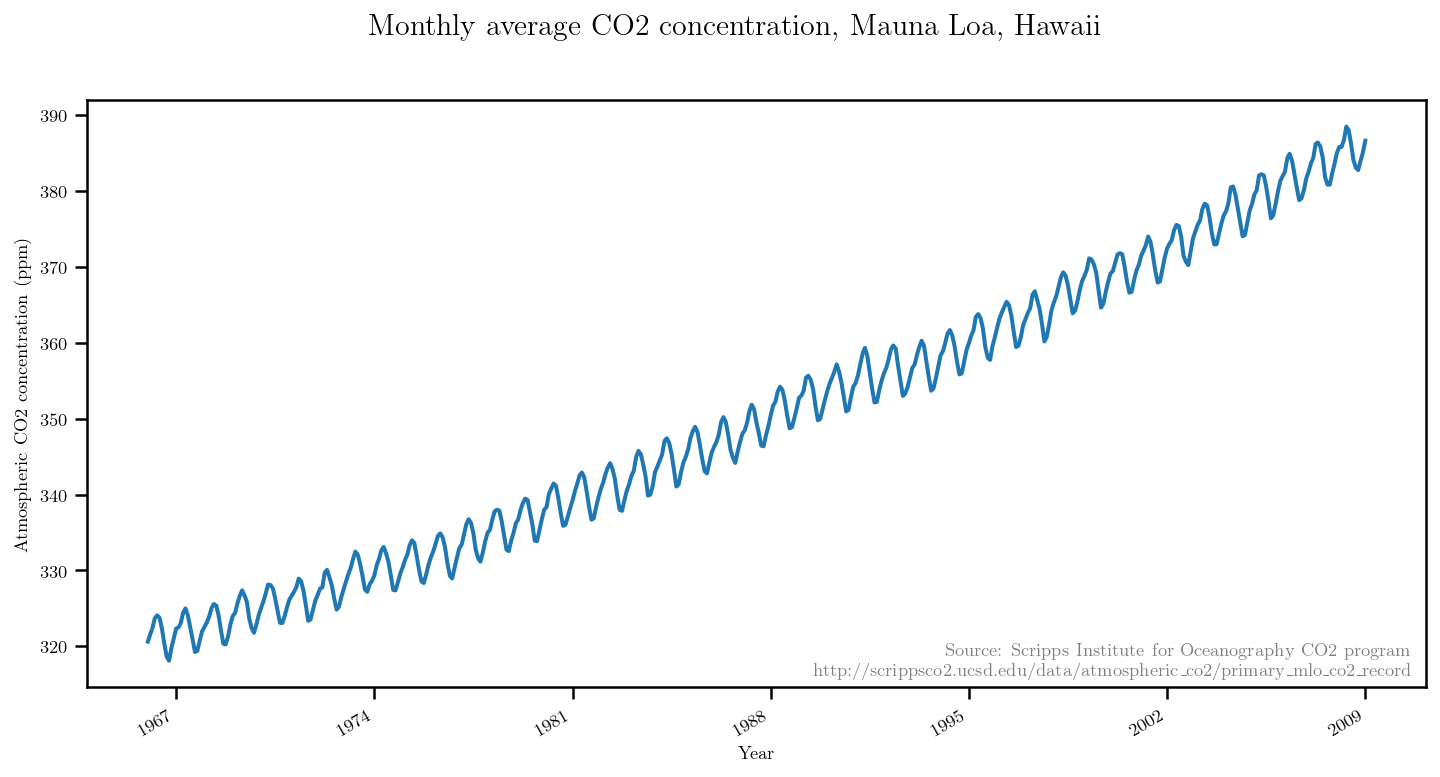

In [11]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(co2_dates[:-num_forecast_steps], co2_by_month_training_data, lw=2, label="training data", markersize=1)
ax.xaxis.set_major_locator(co2_loc)
ax.xaxis.set_major_formatter(co2_fmt)
ax.set_ylabel("Atmospheric CO2 concentration (ppm)")
ax.set_xlabel("Year")
fig.suptitle("Monthly average CO2 concentration, Mauna Loa, Hawaii", fontsize=15)
ax.text(
    0.99,
    0.02,
    "Source: Scripps Institute for Oceanography CO2 program\nhttp://scrippsco2.ucsd.edu/data/atmospheric_co2/primary_mlo_co2_record",
    transform=ax.transAxes,
    horizontalalignment="right",
    alpha=0.5,
)
fig.autofmt_xdate()

# fig.savefig("sts-mauna-loa-data.pdf")

### Model and Fitting

We'll model this series with a local linear trend, plus a month-of-year seasonal effect.

In [12]:
def build_model(observed_time_series):
    trend = sts.LocalLinearTrend(observed_time_series=observed_time_series)
    seasonal = tfp.sts.Seasonal(num_seasons=12, observed_time_series=observed_time_series)
    model = sts.Sum([trend, seasonal], observed_time_series=observed_time_series)
    return model

We'll fit the model using variational inference. This involves running an optimizer to minimize a variational loss function, the negative evidence lower bound (ELBO). This fits a set of approximate posterior distributions for the parameters (in practice we assume these to be independent Normals transformed to the support space of each parameter).

The `tfp.sts` forecasting methods require posterior samples as inputs, so we'll finish by drawing a set of samples from the variational posterior.

In [13]:
co2_model = build_model(co2_by_month_training_data)

# Build the variational surrogate posteriors `qs`.
# Seed contols initial variational params
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=co2_model, seed=seed)

Instructions for updating:
Please use `StructuralTimeSeries.joint_distribution(observed_time_series).log_prob`
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2022-07-13 19:31:54.147979: I tensorflow/compiler/xla/service/service.cc:170] XLA service 0x1268d520 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-07-13 19:31:54.148064: I tensorflow/compiler/xla/service/service.cc:178]   StreamExecutor device (0): Host, Default Version
2022-07-13 19:31:54.291846: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:263] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-07-13 19:31:59.386813: I tensorflow/compiler/jit/xla_compilation_cache.cc:478] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


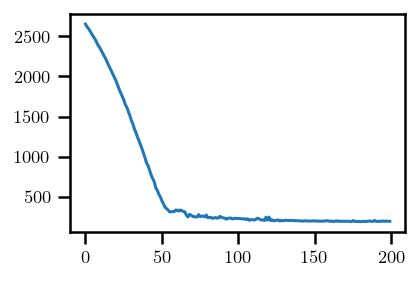

In [14]:
# Minimize the variational loss.

# Seems to converge after 100, but need to run longer to get good predictive performance
num_variational_steps = 200
num_variational_steps = int(num_variational_steps)

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=co2_model.joint_log_prob(observed_time_series=co2_by_month_training_data),
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True,
    seed=seed,
)

plt.plot(elbo_loss_curve)
plt.show()

In [15]:
# Draw samples from the variational posterior.
q_samples_co2_ = variational_posteriors.sample(50, seed=seed)

In [16]:
print("Inferred parameters:")
for param in co2_model.parameters:
    print(
        "{}: {} +- {}".format(
            param.name, np.mean(q_samples_co2_[param.name], axis=0), np.std(q_samples_co2_[param.name], axis=0)
        )
    )

Inferred parameters:
observation_noise_scale: 0.16910074651241302 +- 0.010282539762556553
LocalLinearTrend/_level_scale: 0.1723797619342804 +- 0.012896977365016937
LocalLinearTrend/_slope_scale: 0.0044067115522921085 +- 0.0015938874566927552
Seasonal/_drift_scale: 0.047763753682374954 +- 0.00951220653951168


### Forecasting and criticism

Now let's use the fitted model to construct a forecast. We just call `tfp.sts.forecast`, which returns a TensorFlow Distribution instance representing the predictive distribution over future timesteps.

In [17]:
co2_forecast_dist = tfp.sts.forecast(
    co2_model,
    observed_time_series=co2_by_month_training_data,
    parameter_samples=q_samples_co2_,
    num_steps_forecast=num_forecast_steps,
)

In particular, the `mean` and `stddev` of the forecast distribution give us a prediction with marginal uncertainty at each timestep, and we can also draw samples of possible futures.

In [18]:
num_samples = 10

co2_forecast_mean, co2_forecast_scale, co2_forecast_samples = (
    co2_forecast_dist.mean().numpy()[..., 0],
    co2_forecast_dist.stddev().numpy()[..., 0],
    co2_forecast_dist.sample(num_samples, seed=seed).numpy()[..., 0],
)

saving image to fig/sts-mauna-loa-forecast_latexified.pdf
Figure size: [3. 2.]


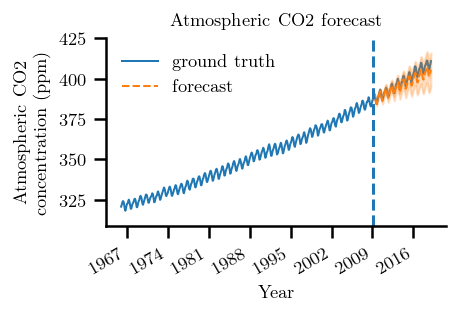

In [19]:
fig, ax = plot_forecast(
    co2_dates,
    co2_by_month,
    co2_forecast_mean,
    co2_forecast_scale,
    co2_forecast_samples,
    x_locator=co2_loc,
    x_formatter=co2_fmt,
    title="Atmospheric CO2 forecast",
)
ax.axvline(co2_dates[-num_forecast_steps], linestyle="--", markersize=1)
ax.legend(loc="upper left", frameon=False)
ax.set_ylabel("Atmospheric CO2 \n concentration (ppm)")
ax.set_xlabel("Year")
fig.autofmt_xdate()
sns.despine()
pml.savefig("sts-mauna-loa-forecast")
# save this figure

We can further understand the model's fit by decomposing it into the contributions of individual time series:

In [20]:
# Build a dict mapping components to distributions over
# their contribution to the observed signal.
component_dists = sts.decompose_by_component(
    co2_model, observed_time_series=co2_by_month, parameter_samples=q_samples_co2_
)

In [21]:
co2_component_means_, co2_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()},
)

In [22]:
latexify(width_scale_factor=2, fig_height=1.5)

saving image to fig/sts-mauna-loa-components_latexified.pdf
Figure size: [3.  1.5]


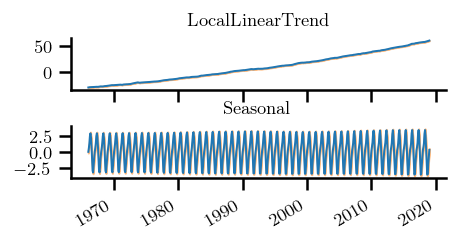

In [23]:
fig, axes_dict = plot_components(
    co2_dates, co2_component_means_, co2_component_stddevs_, x_locator=co2_loc, x_formatter=co2_fmt
)
sns.despine()
pml.savefig("sts-mauna-loa-components")
# save this fig

OrderedDict([('LocalLinearTrend/', <Figure size 216x108 with 1 Axes>), ('Seasonal/', <Figure size 216x108 with 1 Axes>)])


<Figure size 216x108 with 0 Axes>

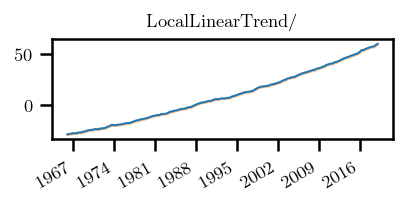

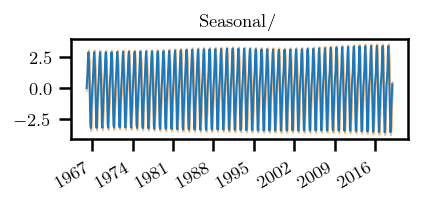

In [24]:
fig_dict = plot_components_figs(
    co2_dates, co2_component_means_, co2_component_stddevs_, x_locator=co2_loc, x_formatter=co2_fmt
)
print(fig_dict)

In [25]:
f = fig_dict["LocalLinearTrend/"]
# f.savefig("sts-mauna-loa-component-linear.pdf")

f = fig_dict["Seasonal/"]
# f.savefig("sts-mauna-loa-component-seasonal.pdf")

## Electricity demand forecasting

Now let's consider a more complex example: forecasting electricity demand in Victoria Australia.

First, we'll build the dataset:

In [26]:
# Victoria electricity demand dataset, as presented at
# https://otexts.com/fpp2/scatterplots.html
# and downloaded from https://github.com/robjhyndman/fpp2-package/blob/master/data/elecdaily.rda
# This series contains the first eight weeks (starting Jan 1). The original
# dataset was half-hourly data; here we've downsampled to hourly data by taking
# every other timestep.
demand_dates = np.arange("2014-01-01", "2014-02-26", dtype="datetime64[h]")
demand_loc = mdates.WeekdayLocator(byweekday=mdates.WE, interval=2)
demand_fmt = mdates.DateFormatter("%b %d")

demand = np.array(
    "3.794,3.418,3.152,3.026,3.022,3.055,3.180,3.276,3.467,3.620,3.730,3.858,3.851,3.839,3.861,3.912,4.082,4.118,4.011,3.965,3.932,3.693,3.585,4.001,3.623,3.249,3.047,3.004,3.104,3.361,3.749,3.910,4.075,4.165,4.202,4.225,4.265,4.301,4.381,4.484,4.552,4.440,4.233,4.145,4.116,3.831,3.712,4.121,3.764,3.394,3.159,3.081,3.216,3.468,3.838,4.012,4.183,4.269,4.280,4.310,4.315,4.233,4.188,4.263,4.370,4.308,4.182,4.075,4.057,3.791,3.667,4.036,3.636,3.283,3.073,3.003,3.023,3.113,3.335,3.484,3.697,3.723,3.786,3.763,3.748,3.714,3.737,3.828,3.937,3.929,3.877,3.829,3.950,3.756,3.638,4.045,3.682,3.283,3.036,2.933,2.956,2.959,3.157,3.236,3.370,3.493,3.516,3.555,3.570,3.656,3.792,3.950,3.953,3.926,3.849,3.813,3.891,3.683,3.562,3.936,3.602,3.271,3.085,3.041,3.201,3.570,4.123,4.307,4.481,4.533,4.545,4.524,4.470,4.457,4.418,4.453,4.539,4.473,4.301,4.260,4.276,3.958,3.796,4.180,3.843,3.465,3.246,3.203,3.360,3.808,4.328,4.509,4.598,4.562,4.566,4.532,4.477,4.442,4.424,4.486,4.579,4.466,4.338,4.270,4.296,4.034,3.877,4.246,3.883,3.520,3.306,3.252,3.387,3.784,4.335,4.465,4.529,4.536,4.589,4.660,4.691,4.747,4.819,4.950,4.994,4.798,4.540,4.352,4.370,4.047,3.870,4.245,3.848,3.509,3.302,3.258,3.419,3.809,4.363,4.605,4.793,4.908,5.040,5.204,5.358,5.538,5.708,5.888,5.966,5.817,5.571,5.321,5.141,4.686,4.367,4.618,4.158,3.771,3.555,3.497,3.646,4.053,4.687,5.052,5.342,5.586,5.808,6.038,6.296,6.548,6.787,6.982,7.035,6.855,6.561,6.181,5.899,5.304,4.795,4.862,4.264,3.820,3.588,3.481,3.514,3.632,3.857,4.116,4.375,4.462,4.460,4.422,4.398,4.407,4.480,4.621,4.732,4.735,4.572,4.385,4.323,4.069,3.940,4.247,3.821,3.416,3.220,3.124,3.132,3.181,3.337,3.469,3.668,3.788,3.834,3.894,3.964,4.109,4.275,4.472,4.623,4.703,4.594,4.447,4.459,4.137,3.913,4.231,3.833,3.475,3.302,3.279,3.519,3.975,4.600,4.864,5.104,5.308,5.542,5.759,6.005,6.285,6.617,6.993,7.207,7.095,6.839,6.387,6.048,5.433,4.904,4.959,4.425,4.053,3.843,3.823,4.017,4.521,5.229,5.802,6.449,6.975,7.506,7.973,8.359,8.596,8.794,9.030,9.090,8.885,8.525,8.147,7.797,6.938,6.215,6.123,5.495,5.140,4.896,4.812,5.024,5.536,6.293,7.000,7.633,8.030,8.459,8.768,9.000,9.113,9.155,9.173,9.039,8.606,8.095,7.617,7.208,6.448,5.740,5.718,5.106,4.763,4.610,4.566,4.737,5.204,5.988,6.698,7.438,8.040,8.484,8.837,9.052,9.114,9.214,9.307,9.313,9.006,8.556,8.275,7.911,7.077,6.348,6.175,5.455,5.041,4.759,4.683,4.908,5.411,6.199,6.923,7.593,8.090,8.497,8.843,9.058,9.159,9.231,9.253,8.852,7.994,7.388,6.735,6.264,5.690,5.227,5.220,4.593,4.213,3.984,3.891,3.919,4.031,4.287,4.558,4.872,4.963,5.004,5.017,5.057,5.064,5.000,5.023,5.007,4.923,4.740,4.586,4.517,4.236,4.055,4.337,3.848,3.473,3.273,3.198,3.204,3.252,3.404,3.560,3.767,3.896,3.934,3.972,3.985,4.032,4.122,4.239,4.389,4.499,4.406,4.356,4.396,4.106,3.914,4.265,3.862,3.546,3.360,3.359,3.649,4.180,4.813,5.086,5.301,5.384,5.434,5.470,5.529,5.582,5.618,5.636,5.561,5.291,5.000,4.840,4.767,4.364,4.160,4.452,4.011,3.673,3.503,3.483,3.695,4.213,4.810,5.028,5.149,5.182,5.208,5.179,5.190,5.220,5.202,5.216,5.232,5.019,4.828,4.686,4.657,4.304,4.106,4.389,3.955,3.643,3.489,3.479,3.695,4.187,4.732,4.898,4.997,5.001,5.022,5.052,5.094,5.143,5.178,5.250,5.255,5.075,4.867,4.691,4.665,4.352,4.121,4.391,3.966,3.615,3.437,3.430,3.666,4.149,4.674,4.851,5.011,5.105,5.242,5.378,5.576,5.790,6.030,6.254,6.340,6.253,6.039,5.736,5.490,4.936,4.580,4.742,4.230,3.895,3.712,3.700,3.906,4.364,4.962,5.261,5.463,5.495,5.477,5.394,5.250,5.159,5.081,5.083,5.038,4.857,4.643,4.526,4.428,4.141,3.975,4.290,3.809,3.423,3.217,3.132,3.192,3.343,3.606,3.803,3.963,3.998,3.962,3.894,3.814,3.776,3.808,3.914,4.033,4.079,4.027,3.974,4.057,3.859,3.759,4.132,3.716,3.325,3.111,3.030,3.046,3.096,3.254,3.390,3.606,3.718,3.755,3.768,3.768,3.834,3.957,4.199,4.393,4.532,4.516,4.380,4.390,4.142,3.954,4.233,3.795,3.425,3.209,3.124,3.177,3.288,3.498,3.715,4.092,4.383,4.644,4.909,5.184,5.518,5.889,6.288,6.643,6.729,6.567,6.179,5.903,5.278,4.788,4.885,4.363,4.011,3.823,3.762,3.998,4.598,5.349,5.898,6.487,6.941,7.381,7.796,8.185,8.522,8.825,9.103,9.198,8.889,8.174,7.214,6.481,5.611,5.026,5.052,4.484,4.148,3.955,3.873,4.060,4.626,5.272,5.441,5.535,5.534,5.610,5.671,5.724,5.793,5.838,5.908,5.868,5.574,5.276,5.065,4.976,4.554,4.282,4.547,4.053,3.720,3.536,3.524,3.792,4.420,5.075,5.208,5.344,5.482,5.701,5.936,6.210,6.462,6.683,6.979,7.059,6.893,6.535,6.121,5.797,5.152,4.705,4.805,4.272,3.975,3.805,3.775,3.996,4.535,5.275,5.509,5.730,5.870,6.034,6.175,6.340,6.500,6.603,6.804,6.787,6.460,6.043,5.627,5.367,4.866,4.575,4.728,4.157,3.795,3.607,3.537,3.596,3.803,4.125,4.398,4.660,4.853,5.115,5.412,5.669,5.930,6.216,6.466,6.641,6.605,6.316,5.821,5.520,5.016,4.657,4.746,4.197,3.823,3.613,3.505,3.488,3.532,3.716,4.011,4.421,4.836,5.296,5.766,6.233,6.646,7.011,7.380,7.660,7.804,7.691,7.364,7.019,6.260,5.545,5.437,4.806,4.457,4.235,4.172,4.396,5.002,5.817,6.266,6.732,7.049,7.184,7.085,6.798,6.632,6.408,6.218,5.968,5.544,5.217,4.964,4.758,4.328,4.074,4.367,3.883,3.536,3.404,3.396,3.624,4.271,4.916,4.953,5.016,5.048,5.106,5.124,5.200,5.244,5.242,5.341,5.368,5.166,4.910,4.762,4.700,4.276,4.035,4.318,3.858,3.550,3.399,3.382,3.590,4.261,4.937,4.994,5.094,5.168,5.303,5.410,5.571,5.740,5.900,6.177,6.274,6.039,5.700,5.389,5.192,4.672,4.359,4.614,4.118,3.805,3.627,3.646,3.882,4.470,5.106,5.274,5.507,5.711,5.950,6.200,6.527,6.884,7.196,7.615,7.845,7.759,7.437,7.059,6.584,5.742,5.125,5.139,4.564,4.218,4.025,4.000,4.245,4.783,5.504,5.920,6.271,6.549,6.894,7.231,7.535,7.597,7.562,7.609,7.534,7.118,6.448,5.963,5.565,5.005,4.666,4.850,4.302,3.905,3.678,3.610,3.672,3.869,4.204,4.541,4.944,5.265,5.651,6.090,6.547,6.935,7.318,7.625,7.793,7.760,7.510,7.145,6.805,6.103,5.520,5.462,4.824,4.444,4.237,4.157,4.164,4.275,4.545,5.033,5.594,6.176,6.681,6.628,6.238,6.039,5.897,5.832,5.701,5.483,4.949,4.589,4.407,4.027,3.820,4.075,3.650,3.388,3.271,3.268,3.498,4.086,4.800,4.933,5.102,5.126,5.194,5.260,5.319,5.364,5.419,5.559,5.568,5.332,5.027,4.864,4.738,4.303,4.093,4.379,3.952,3.632,3.461,3.446,3.732,4.294,4.911,5.021,5.138,5.223,5.348,5.479,5.661,5.832,5.966,6.178,6.212,5.949,5.640,5.449,5.213,4.678,4.376,4.601,4.147,3.815,3.610,3.605,3.879,4.468,5.090,5.226,5.406,5.561,5.740,5.899,6.095,6.272,6.402,6.610,6.585,6.265,5.925,5.747,5.497,4.932,4.580,4.763,4.298,4.026,3.871,3.827,4.065,4.643,5.317,5.494,5.685,5.814,5.912,5.999,6.097,6.176,6.136,6.131,6.049,5.796,5.532,5.475,5.254,4.742,4.453,4.660,4.176,3.895,3.726,3.717,3.910,4.479,5.135,5.306,5.520,5.672,5.737,5.785,5.829,5.893,5.892,5.921,5.817,5.557,5.304,5.234,5.074,4.656,4.396,4.599,4.064,3.749,3.560,3.475,3.552,3.783,4.045,4.258,4.539,4.762,4.938,5.049,5.037,5.066,5.151,5.197,5.201,5.132,4.908,4.725,4.568,4.222,3.939,4.215,3.741,3.380,3.174,3.076,3.071,3.172,3.328,3.427,3.603,3.738,3.765,3.777,3.705,3.690,3.742,3.859,4.032,4.113,4.032,4.066,4.011,3.712,3.530,3.905,3.556,3.283,3.136,3.146,3.400,4.009,4.717,4.827,4.909,4.973,5.036,5.079,5.160,5.228,5.241,5.343,5.350,5.184,4.941,4.797,4.615,4.160,3.904,4.213,3.810,3.528,3.369,3.381,3.609,4.178,4.861,4.918,5.006,5.102,5.239,5.385,5.528,5.724,5.845,6.048,6.097,5.838,5.507,5.267,5.003,4.462,4.184,4.431,3.969,3.660,3.480,3.470,3.693,4.313,4.955,5.083,5.251,5.268,5.293,5.285,5.308,5.349,5.322,5.328,5.151,4.975,4.741,4.678,4.458,4.056,3.868,4.226,3.799,3.428,3.253,3.228,3.452,4.040,4.726,4.709,4.721,4.741,4.846,4.864,4.868,4.836,4.799,4.890,4.946,4.800,4.646,4.693,4.546,4.117,3.897,4.259,3.893,3.505,3.341,3.334,3.623,4.240,4.925,4.986,5.028,4.987,4.984,4.975,4.912,4.833,4.686,4.710,4.718,4.577,4.454,4.532,4.407,4.064,3.883,4.221,3.792,3.445,3.261,3.221,3.295,3.521,3.804,4.038,4.200,4.226,4.198,4.182,4.078,4.018,4.002,4.066,4.158,4.154,4.084,4.104,4.001,3.773,3.700,4.078,3.702,3.349,3.143,3.052,3.070,3.181,3.327,3.440,3.616,3.678,3.694,3.710,3.706,3.764,3.852,4.009,4.202,4.323,4.249,4.275,4.162,3.848,3.706,4.060,3.703,3.401,3.251,3.239,3.455,4.041,4.743,4.815,4.916,4.931,4.966,5.063,5.218,5.381,5.458,5.550,5.566,5.376,5.104,5.022,4.793,4.335,4.108,4.410,4.008,3.666,3.497,3.464,3.698,4.333,4.998,5.094,5.272,5.459,5.648,5.853,6.062,6.258,6.236,6.226,5.957,5.455,5.066,4.968,4.742,4.304,4.105,4.410".split(
        ","
    )
).astype(np.float32)
temperature = np.array(
    "18.050,17.200,16.450,16.650,16.400,17.950,19.700,20.600,22.350,23.700,24.800,25.900,25.300,23.650,20.700,19.150,22.650,22.650,22.400,22.150,22.050,22.150,21.000,19.500,18.450,17.250,16.300,15.700,15.500,15.450,15.650,16.500,18.100,17.800,19.100,19.850,20.300,21.050,22.800,21.650,20.150,19.300,18.750,17.900,17.350,16.850,16.350,15.700,14.950,14.500,14.350,14.450,14.600,14.600,14.700,15.450,16.700,18.300,20.100,20.650,19.450,20.200,20.250,20.050,20.250,20.950,21.900,21.000,19.900,19.250,17.300,16.300,15.800,15.000,14.400,14.050,13.650,13.500,14.150,15.300,14.800,17.050,18.350,19.450,18.550,18.650,18.850,19.800,19.650,18.900,19.500,17.700,17.350,16.950,16.400,15.950,14.900,14.250,13.050,12.000,11.500,10.950,12.300,16.100,17.100,19.600,21.100,22.600,24.350,25.250,25.750,20.350,15.550,18.300,19.400,19.250,18.550,17.700,16.750,15.800,14.900,14.050,14.100,13.500,13.000,12.950,13.300,13.900,15.400,16.750,17.300,17.750,18.400,18.500,18.800,19.450,18.750,18.400,16.950,15.800,15.350,15.250,15.150,14.900,14.500,14.600,14.400,14.150,14.300,14.500,14.950,15.550,15.800,15.550,16.450,17.500,17.700,18.750,19.600,19.900,19.350,19.550,17.900,16.400,15.550,14.900,14.400,13.950,13.300,12.950,12.650,12.450,12.350,12.150,11.950,14.150,15.850,17.750,19.450,22.150,23.850,23.450,24.950,26.850,26.100,25.150,23.250,21.300,19.850,18.900,18.250,17.450,17.100,16.400,15.550,15.050,14.400,14.550,15.150,17.050,18.850,20.850,24.250,27.700,28.400,30.750,30.700,32.200,31.750,30.650,29.750,28.850,27.850,25.950,24.700,24.850,24.050,23.850,23.500,22.950,22.200,21.750,22.350,24.050,25.150,27.100,28.050,29.750,31.250,31.900,32.950,33.150,33.950,33.850,33.250,32.500,31.500,28.300,23.900,22.900,22.300,21.250,20.500,19.850,18.850,18.300,18.100,18.200,18.150,18.000,17.700,18.250,19.700,20.750,21.800,21.500,21.600,20.800,19.400,18.400,17.900,17.600,17.550,17.550,17.650,17.400,17.150,16.800,17.000,16.900,17.200,17.350,17.650,17.800,18.400,19.300,20.200,21.050,21.700,21.800,21.800,21.500,20.000,19.300,18.200,18.100,17.700,16.950,16.250,15.600,15.500,15.300,15.450,15.500,15.750,17.350,19.150,21.650,24.700,25.200,24.300,26.900,28.100,29.450,29.850,29.450,26.350,27.050,25.700,25.150,23.850,22.450,21.450,20.850,20.700,21.300,21.550,20.800,22.300,26.300,32.600,35.150,36.800,38.150,39.950,40.850,41.250,42.300,41.950,41.350,40.600,36.350,36.150,34.600,34.050,35.400,36.300,35.550,33.700,30.650,29.450,29.500,31.000,33.300,35.700,36.650,37.650,39.400,40.600,40.250,37.550,37.300,35.400,32.750,31.200,29.600,28.350,27.500,28.750,28.900,29.900,28.700,28.650,28.150,28.250,27.650,27.800,29.450,32.500,35.750,38.850,39.900,41.100,41.800,42.750,39.900,39.750,40.800,37.950,31.250,34.600,30.250,28.500,27.900,27.950,27.300,26.900,26.800,26.050,26.100,27.700,31.850,34.850,36.350,38.000,39.200,41.050,41.600,42.350,43.100,33.500,30.700,29.100,26.400,23.900,24.700,24.350,23.450,23.450,23.550,23.050,22.200,22.100,22.000,21.900,22.050,22.550,22.850,22.450,22.250,22.650,22.350,21.900,21.000,20.950,20.200,19.700,19.400,19.200,18.650,18.150,18.150,17.650,17.350,17.150,16.800,16.750,16.400,16.500,16.700,17.300,17.750,19.200,20.400,20.900,21.450,22.000,22.100,21.600,21.700,20.500,19.850,19.750,19.500,19.200,19.800,19.500,19.200,19.200,19.150,19.050,19.100,19.250,19.550,20.200,20.550,21.450,23.150,23.500,23.400,23.500,23.300,22.850,22.250,20.950,19.750,19.450,18.900,18.450,17.950,17.550,17.300,16.950,16.900,16.850,17.100,17.250,17.400,17.850,18.100,18.600,19.700,21.000,21.400,22.650,22.550,22.000,21.050,19.550,18.550,18.300,17.750,17.800,17.650,17.800,17.450,16.950,16.500,16.900,17.050,16.750,17.300,18.800,19.350,20.750,21.400,21.900,21.950,22.800,22.750,23.200,22.650,20.800,19.250,17.800,16.950,16.550,16.050,15.750,15.150,14.700,14.150,13.900,13.900,14.000,15.800,17.650,19.700,22.500,25.300,24.300,24.650,26.450,27.250,26.550,28.800,27.850,25.200,24.750,23.750,22.550,22.350,21.700,21.300,20.300,20.050,20.500,21.250,20.850,21.000,19.400,18.900,18.150,18.650,20.200,20.000,21.650,21.950,21.150,20.400,19.500,19.150,18.400,18.050,17.750,17.600,17.150,16.750,16.350,16.250,15.900,15.850,15.900,16.200,18.500,18.750,18.800,19.850,19.750,19.600,19.300,20.000,20.250,19.700,18.600,17.400,17.100,16.650,16.250,16.250,15.800,15.350,14.800,14.250,13.500,13.400,14.350,15.800,17.700,19.000,21.050,22.200,22.450,24.950,24.750,25.050,26.400,26.200,26.500,25.850,24.400,23.600,22.650,21.500,20.150,19.900,18.850,18.700,18.750,18.650,20.050,23.450,24.900,26.450,28.550,30.600,31.550,32.800,33.500,33.700,34.450,34.200,33.650,32.900,31.750,30.500,29.250,28.100,26.450,25.400,25.400,25.150,25.400,25.100,25.950,28.100,30.400,32.000,33.750,34.700,35.800,37.000,39.050,39.750,41.200,41.050,36.050,28.250,24.450,23.150,22.050,21.600,21.450,20.800,20.250,19.700,19.400,19.650,19.100,18.650,18.900,19.400,20.700,21.750,22.350,24.100,23.350,24.400,22.950,22.400,20.950,19.600,18.900,18.000,17.400,16.800,16.550,16.300,16.250,16.750,16.700,17.100,17.500,18.150,18.850,20.650,22.600,25.600,28.500,26.750,27.200,27.300,27.500,27.000,25.450,24.500,23.850,23.200,22.550,21.850,21.050,20.200,19.950,20.400,20.300,20.100,20.450,20.900,21.450,21.800,23.250,24.100,25.200,25.550,25.900,25.450,26.050,25.350,23.900,22.250,22.000,21.700,21.450,20.550,19.000,18.850,18.700,19.050,19.350,19.350,19.450,19.600,20.550,22.400,24.550,26.900,27.950,28.500,28.200,29.050,28.700,28.800,27.150,24.900,23.500,23.350,23.000,22.300,21.400,20.700,19.850,19.400,19.250,18.700,18.650,20.200,23.400,26.400,27.450,29.150,32.050,34.500,34.950,36.550,37.850,38.400,35.150,34.050,34.100,33.100,30.300,29.300,27.550,26.600,25.900,25.500,25.150,25.000,25.150,27.000,31.150,32.750,31.500,26.900,23.900,23.150,22.850,21.500,21.150,21.300,19.700,18.800,18.450,18.300,17.800,16.850,16.400,16.150,15.700,15.500,15.400,15.300,15.050,15.650,18.100,19.200,21.050,22.350,23.450,24.850,24.950,25.550,25.300,24.250,22.750,20.850,19.350,18.250,17.450,17.000,16.500,16.100,15.950,15.300,14.550,14.250,14.400,15.550,18.300,20.000,22.750,25.450,25.800,26.350,29.150,30.450,30.350,29.600,27.550,25.550,23.650,22.950,21.850,20.700,20.150,19.300,19.000,18.400,17.800,17.750,18.000,20.800,23.400,25.750,27.750,29.600,32.150,32.900,33.650,34.300,34.800,35.050,33.750,33.250,32.400,31.250,29.650,28.550,26.550,25.950,25.000,24.400,24.150,24.150,24.350,26.900,28.750,30.350,32.750,34.250,35.300,28.400,27.250,26.600,25.750,25.350,23.150,21.550,20.850,20.550,20.350,20.550,20.600,19.900,19.550,19.200,18.900,18.850,19.250,21.000,23.050,25.350,27.700,31.050,35.250,35.100,36.850,39.250,40.000,39.450,38.950,37.750,33.850,30.400,25.700,25.400,25.600,28.150,32.400,31.850,31.350,31.200,31.100,31.950,32.450,35.200,38.400,35.850,30.700,27.850,26.900,26.650,25.250,24.450,22.500,22.050,20.000,19.750,19.100,18.500,18.400,17.400,16.900,16.800,16.450,16.050,16.300,17.450,19.300,20.000,21.050,22.800,22.550,23.300,24.050,23.100,23.100,22.500,20.800,19.550,18.800,18.200,17.650,17.750,17.150,16.550,16.200,16.000,15.600,15.150,15.150,16.250,17.800,19.150,21.000,22.800,23.850,24.250,26.200,25.650,25.050,23.850,23.600,23.100,22.950,22.550,21.550,20.450,19.600,18.700,18.300,18.000,17.550,17.300,17.200,17.950,19.450,21.100,23.050,24.650,25.050,25.850,25.300,26.650,25.500,25.900,26.250,25.300,25.150,23.600,22.050,21.700,21.150,20.550,20.500,20.200,20.500,20.600,20.900,21.700,22.000,22.250,23.400,23.900,25.250,26.200,26.000,25.300,25.200,25.300,25.500,25.350,25.050,24.850,24.050,23.150,22.300,21.900,21.150,20.300,19.650,19.700,19.750,20.250,21.500,23.600,24.600,25.900,25.450,24.850,25.900,26.150,26.250,26.350,26.250,25.850,25.300,24.600,23.750,22.250,21.750,21.450,21.500,21.300,21.250,21.200,21.600,22.000,23.650,25.200,26.400,25.500,25.150,26.950,28.350,25.650,25.000,25.500,24.150,22.900,21.600,21.750,21.500,21.550,20.450,19.500,18.750,18.650,18.200,17.300,17.900,18.050,17.400,16.850,17.950,20.550,21.950,22.600,22.300,22.400,22.300,21.100,20.250,19.200,18.900,18.600,18.350,17.700,17.200,16.850,16.900,16.800,16.800,16.600,16.350,17.200,18.350,19.550,20.300,21.600,21.800,23.300,23.200,24.550,24.950,24.900,23.700,22.000,19.650,18.250,17.700,17.250,16.900,16.550,16.050,16.450,15.400,14.900,14.700,16.100,18.450,19.800,23.000,25.250,27.600,27.900,28.550,29.450,29.700,29.350,27.000,23.550,21.900,20.750,20.150,19.600,19.150,18.800,18.550,18.200,17.750,17.650,17.800,18.750,19.600,20.450,21.950,23.700,23.150,24.150,24.550,21.400,19.150,19.050,16.500,15.900,14.850,15.300,14.100,13.800,13.600,13.450,13.400,13.050,12.750,12.800,12.750,13.600,14.950,16.100,17.500,18.500,19.300,19.400,19.750,19.400,19.450,19.450,18.900,17.650,16.800,15.900,15.050,14.550,14.250,13.800,13.850,13.700,13.650,13.350,13.400,14.050,15.000,16.650,17.850,18.450,18.200,18.900,19.850,20.000,19.700,18.800,17.500,16.600,16.250,16.000,16.300,16.400,15.800,15.850,14.600,14.650,15.200,14.900,14.600,15.150,16.000,16.350,17.000,18.300,19.050,19.300,19.400,18.650,18.750,19.100,18.300,17.950,17.550,16.900,16.450,15.850,15.800,15.650,15.200,14.700,14.950,15.250,15.200,15.800,16.800,17.900,19.700,21.050,21.600,22.550,22.750,22.900,22.500,21.950,20.450,19.600,19.200,18.000,16.950,16.450,16.150,15.600,15.150,15.250,15.200,14.750,15.050,15.600,17.750,18.450,20.050,21.350,22.500,23.550,24.100,22.600,23.150,24.100,22.650,21.250,19.900,19.100,18.250,17.750,17.500,16.600,16.100,15.850,15.750,15.700,16.350,19.600,25.750,27.800,30.050,32.350,31.900,32.450,29.600,28.850,23.450,21.100,20.100,20.100,19.900,19.300,19.050,18.850".split(
        ","
    )
).astype(np.float32)

num_forecast_steps = 24 * 7 * 2  # Two weeks.
demand_training_data = demand[:-num_forecast_steps]

In [27]:
latexify(width_scale_factor=2, fig_height=2, font_size=7)

saving image to fig/sts-electricity-data_latexified.pdf
Figure size: [3. 2.]


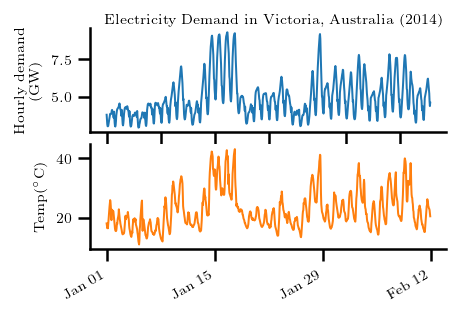

In [28]:
colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure()
ax = fig.add_subplot(2, 1, 1)
ax.plot(demand_dates[:-num_forecast_steps], demand[:-num_forecast_steps], lw=1, label="training data")
ax.set_ylabel("Hourly demand\n (GW)")

ax = fig.add_subplot(2, 1, 2)

ax.plot(demand_dates[:-num_forecast_steps], temperature[:-num_forecast_steps], lw=1, label="training data", c=c2)
ax.set_ylabel(f"Temp" + r"($^{\circ}$C)")

ax.xaxis.set_major_locator(demand_loc)
ax.xaxis.set_major_formatter(demand_fmt)
fig.suptitle("Electricity Demand in Victoria, Australia (2014)", x=0.6, y=1)
fig.autofmt_xdate()
sns.despine()
pml.savefig("sts-electricity-data")

# fig.savefig("sts-electricity-data.pdf")

### Model and fitting

Our model combines a hour-of-day and day-of-week seasonality, with a linear regression modeling the effect of temperature, and an autoregressive process to handle bounded-variance residuals.

In [29]:
def build_model(observed_time_series):
    hour_of_day_effect = sts.Seasonal(
        num_seasons=24, observed_time_series=observed_time_series, name="hour_of_day_effect"
    )
    day_of_week_effect = sts.Seasonal(
        num_seasons=7, num_steps_per_season=24, observed_time_series=observed_time_series, name="day_of_week_effect"
    )
    temperature_effect = sts.LinearRegression(
        design_matrix=tf.reshape(temperature - np.mean(temperature), (-1, 1)), name="temperature_effect"
    )
    autoregressive = sts.Autoregressive(order=1, observed_time_series=observed_time_series, name="autoregressive")
    model = sts.Sum(
        [hour_of_day_effect, day_of_week_effect, temperature_effect, autoregressive],
        observed_time_series=observed_time_series,
    )
    return model

As above, we'll fit the model with variational inference and draw samples from the posterior.

In [30]:
demand_model = build_model(demand_training_data)

# Build the variational surrogate posteriors `qs`.
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=demand_model, seed=seed)

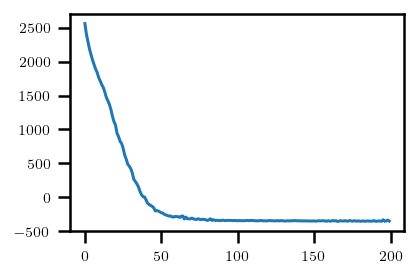

In [31]:
# Minimize the variational loss.

# Allow external control of optimization to reduce test runtimes.
num_variational_steps = 200
num_variational_steps = int(num_variational_steps)

# Build and optimize the variational loss function.
elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
    target_log_prob_fn=demand_model.joint_log_prob(observed_time_series=demand_training_data),
    surrogate_posterior=variational_posteriors,
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    num_steps=num_variational_steps,
    jit_compile=True,
    seed=seed,
)
plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_demand_ = variational_posteriors.sample(50)

In [32]:
print("Inferred parameters:")
for param in demand_model.parameters:
    print(
        "{}: {} +- {}".format(
            param.name, np.mean(q_samples_demand_[param.name], axis=0), np.std(q_samples_demand_[param.name], axis=0)
        )
    )

Inferred parameters:
observation_noise_scale: 0.010351925157010555 +- 0.0020247127395123243
hour_of_day_effect/_drift_scale: 0.0011781816137954593 +- 0.0007347692153416574
day_of_week_effect/_drift_scale: 0.012210402637720108 +- 0.010224307887256145
temperature_effect/_weights: [0.06971042] +- [0.00451957]
autoregressive/_coefficients: [0.98808867] +- [0.00327637]
autoregressive/_level_scale: 0.15506894886493683 +- 0.002806552452966571


### Forecasting and criticism

Again, we create a forecast simply by calling `tfp.sts.forecast` with our model, time series, and sampled parameters.

In [33]:
demand_forecast_dist = tfp.sts.forecast(
    model=demand_model,
    observed_time_series=demand_training_data,
    parameter_samples=q_samples_demand_,
    num_steps_forecast=num_forecast_steps,
)

In [34]:
num_samples = 10

(demand_forecast_mean, demand_forecast_scale, demand_forecast_samples) = (
    demand_forecast_dist.mean().numpy()[..., 0],
    demand_forecast_dist.stddev().numpy()[..., 0],
    demand_forecast_dist.sample(num_samples, seed=seed).numpy()[..., 0],
)

In [35]:
latexify(width_scale_factor=2, fig_height=2)

saving image to fig/sts-electricity-forecast_latexified.pdf
Figure size: [3. 2.]


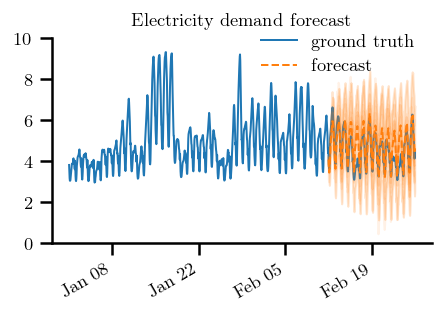

In [36]:
fig, ax = plot_forecast(
    demand_dates,
    demand,
    demand_forecast_mean,
    demand_forecast_scale,
    demand_forecast_samples,
    title="Electricity demand forecast",
    x_locator=demand_loc,
    x_formatter=demand_fmt,
)
sns.despine()
ax.legend(loc=1, frameon=False, bbox_to_anchor=(1, 1.1))
ax.set_ylim([0, 10])
fig.tight_layout()
pml.savefig("sts-electricity-forecast")
# fig.savefig("sts-electricity-forecast.pdf")

Let's visualize the decomposition of the observed and forecast series into the individual components:

In [37]:
# Get the distributions over component outputs from the posterior marginals on
# training data, and from the forecast model.
component_dists = sts.decompose_by_component(
    demand_model, observed_time_series=demand_training_data, parameter_samples=q_samples_demand_
)

forecast_component_dists = sts.decompose_forecast_by_component(
    demand_model, forecast_dist=demand_forecast_dist, parameter_samples=q_samples_demand_
)

In [38]:
demand_component_means_, demand_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()},
)

(demand_forecast_component_means_, demand_forecast_component_stddevs_) = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()},
)

/tmp/ipykernel_495/2000814276.py:24: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


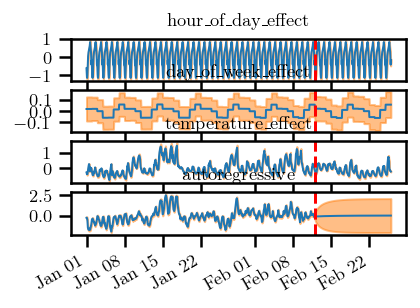

In [39]:
# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate(
        [demand_component_means_[k], demand_forecast_component_means_[k]], axis=-1
    )
    component_with_forecast_stddevs_[k] = np.concatenate(
        [demand_component_stddevs_[k], demand_forecast_component_stddevs_[k]], axis=-1
    )


fig, axes = plot_components(
    demand_dates,
    component_with_forecast_means_,
    component_with_forecast_stddevs_,
    x_locator=demand_loc,
    x_formatter=demand_fmt,
)
for ax in axes.values():
    ax.axvline(demand_dates[-num_forecast_steps], linestyle="--", color="red")
plt.show()
# pml.savefig("sts-electricity-components")

# fig.savefig("sts-electricity-components.pdf")

If we wanted to detect anomalies in the observed series, we might also be interested in the one-step predictive distributions: the forecast for each timestep, given only the timesteps up to that point. `tfp.sts.one_step_predictive` computes all of the one-step predictive distributions in a single pass:

In [40]:
demand_one_step_dist = sts.one_step_predictive(
    demand_model, observed_time_series=demand, parameter_samples=q_samples_demand_
)

demand_one_step_mean, demand_one_step_scale = (
    demand_one_step_dist.mean().numpy(),
    demand_one_step_dist.stddev().numpy(),
)

Instructions for updating:
`Predictive distributions returned by`tfp.sts.one_step_predictive` will soon compute per-timestep probabilities (treating timesteps as part of the batch shape) instead of a single probability for an entire series (the current approach, in which timesteps are treated as event shape). Please update your code to pass `timesteps_are_event_shape=False` (this will soon be the default) and to explicitly sum over the per-timestep log probabilities if this is required.


In [41]:
latexify(width_scale_factor=1, fig_height=2)

A simple anomaly detection scheme is to flag all timesteps where the observations are more than three stddevs from the predicted value -- these are the most 'surprising' timesteps according to the model.

saving image to fig/sts-electricity-anomalies_latexified.pdf
Figure size: [6. 2.]


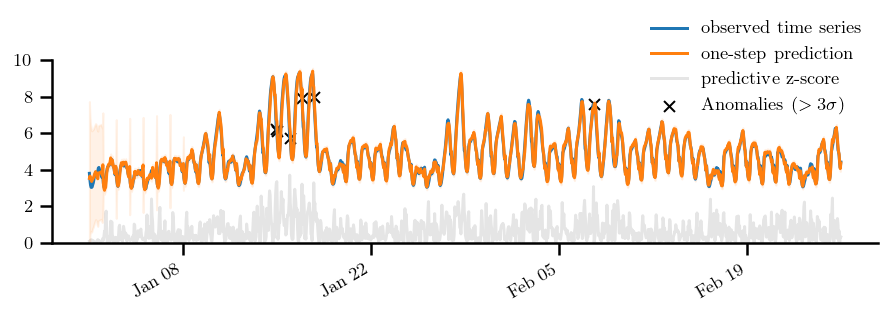

In [42]:
fig, ax = plot_one_step_predictive(
    demand_dates, demand, demand_one_step_mean, demand_one_step_scale, x_locator=demand_loc, x_formatter=demand_fmt
)
ax.set_ylim(0, 10)

# Use the one-step-ahead forecasts to detect anomalous timesteps.
zscores = np.abs((demand - demand_one_step_mean) / demand_one_step_scale)
anomalies = zscores > 3.0
ax.plot(demand_dates, zscores, color="black", alpha=0.1, label="predictive z-score")
ax.scatter(
    demand_dates[anomalies],
    demand[anomalies],
    c="#000000",
    marker="x",
    s=30,
    linewidth=1,
    label=r"Anomalies ($>3\sigma$)",
)
ax.legend(frameon=False, loc=1, bbox_to_anchor=(1, 1.3))
sns.despine()
pml.savefig("sts-electricity-anomalies")
# fig.savefig("sts-electricity-anomalies.pdf")
plt.show()